# Swimming races

In this notebook we will analyze different aspects from the swimming competition 2015 FINA World Champioships, in Kazán, Rusia.

Some background:
* There are 10 lines in the pool indexed from 0 to 9.
* Strokes: Freestyle, Breaststroke, Butterfly, Backstroke, Medley.
* Each event is defined by a unique tuple of gender, distance and stroke.
* Each event is swum in stages, called rounds, with the fastest swimmers from each round progressing in the competition. 
Rounds: heat, semifinal, final.

## Data Source
The data is freely available at OMEGA from omegatiming.com

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as ps
import dc_stat_think as dcst

In [110]:
pd.set_option('max_columns', None)
df = pd.read_csv (r'2015_FINA.csv',skiprows=4)
df.head(5)

,athleteid,lastname,firstname,birthdate,gender,name,code,eventid,heat,lane,points,reactiontime,swimtime,split,cumswimtime,splitdistance,daytime,round,distance,relaycount,stroke,splitswimtime
0,100784,BORSHI,NOEL,1996-02-13,F,Albania,ALB,1,1,4,680.0,0.77,63.65,1,29.63,50,930.0,PRE,100,1,FLY,29.63
1,100784,BORSHI,NOEL,1996-02-13,F,Albania,ALB,1,1,4,680.0,0.77,63.65,2,63.65,100,930.0,PRE,100,1,FLY,34.02
2,100784,BORSHI,NOEL,1996-02-13,F,Albania,ALB,20,1,8,654.0,0.80,140.28,1,31.33,50,1014.0,PRE,200,1,FLY,31.33
3,100784,BORSHI,NOEL,1996-02-13,F,Albania,ALB,20,1,8,654.0,0.80,140.28,2,66.81,100,1014.0,PRE,200,1,FLY,35.48
4,100784,BORSHI,NOEL,1996-02-13,F,Albania,ALB,20,1,8,654.0,0.80,140.28,3,103.29,150,1014.0,PRE,200,1,FLY,36.48


In [111]:
df['split'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [112]:
df['round'].unique()

array(['PRE', 'SEM', 'FIN', 'SOS', 'SOP'], dtype=object)

In [113]:
df['distance'].unique()

array([ 100,  200,  400,   50,  800, 1500])

In [114]:
df['stroke'].unique()

array(['FLY', 'FREE', 'BACK', 'BREAST', 'MEDLEY'], dtype=object)

# First topic: Graphical EDA of men's 200 free heats


## The dataset

In [101]:
q1 = """SELECT swimtime FROM df WHERE gender='M'AND distance=200 AND splitdistance=200 AND stroke='FREE' AND round='PRE'"""
mens_200_free_heats=ps.sqldf(q1)
mens_200_free_heats=mens_200_free_heats.to_numpy().reshape(-1)
#print(mens_200_free_heats)

## Graphical EDA

In the heats, all contestants swim, the very fast and the very slow. To explore how the swim times are distributed, plot an ECDF of the men's 200 freestyle.

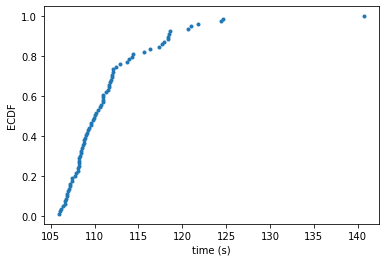

In [7]:
# Generate x and y values for ECDF: x, y
x, y = dcst.ecdf(mens_200_free_heats)

# Plot the ECDF as dots
_=plt.plot(x,y,marker='.',linestyle='none')

# Label axes and show plot
_=plt.xlabel('time (s)')
_=plt.ylabel('ECDF')
plt.show()

We see that fast swimmers are below 115 seconds, with a smattering of slow swimmers past that, including one very slow swimmer.


## 200 m free time with confidence interval
Now, you will practice parameter estimation and computation of confidence intervals by computing the mean and median swim time for the men's 200 freestyle heats. The median is useful because it is immune to heavy tails in the distribution of swim times, such as the slow swimmers in the heats. mens_200_free_heats is still in your namespace.

In [102]:
# Compute mean and median swim times
mean_time = np.mean(mens_200_free_heats)
median_time = np.median(mens_200_free_heats)

# Draw 10,000 bootstrap replicates of the mean and median
bs_reps_mean = dcst.draw_bs_reps(mens_200_free_heats,np.mean,size=10000)
bs_reps_median = dcst.draw_bs_reps(mens_200_free_heats,np.median,size=10000)


# Compute the 95% confidence intervals
conf_int_mean = np.percentile(bs_reps_mean,[2.5,97.5])
conf_int_median = np.percentile(bs_reps_median,[2.5,97.5])

# Print the result to the screen
print("""
mean time: {0:.2f} sec.
95% conf int of mean: [{1:.2f}, {2:.2f}] sec.

median time: {3:.2f} sec.
95% conf int of median: [{4:.2f}, {5:.2f}] sec.
""".format(mean_time, *conf_int_mean, median_time, *conf_int_median))


mean time: 111.63 sec.
95% conf int of mean: [110.50, 112.90] sec.

median time: 110.04 sec.
95% conf int of median: [108.96, 111.01] sec.



Indeed, the mean swim time is longer than the median because of the effect of the very slow swimmers.

# Second topic: Do swimmers go faster in the finals?

We need to pose our question in a more specific way:
Do individual female swimmers swim faster in the finals compared to the semifinals?

Implicit in this questions are the folowing facts:
* We should use events that have semifinals: 50, 100 and 200 meters, freestyle, breaststroke, butterfly and backstroke.
* A reasonable metric for improvement is the fractional improvement: (semifinals_time - final_time)/semifinal_time

## The datasets

In [106]:
q_all="""SELECT DISTINCT sem.athleteid,sem.distance, sem.stroke, sem.round as sem_round, fin.round as fin_round,
sem.swimtime AS sem_swimtime, fin.swimtime AS fin_swimtime
FROM df AS sem INNER JOIN df AS fin 
ON (sem.athleteid=fin.athleteid AND sem.distance=fin.distance AND sem.stroke=fin.stroke)
WHERE sem.round='SEM' AND fin.round='FIN' AND sem.gender='F'AND  sem.stroke != 'MEDLEY'AND sem.distance IN (50,100,200)"""
#df_all=ps.sqldf(q_all)



In [103]:
q_semi="""SELECT sem_swimtime FROM df_all"""
df_semi_times=ps.sqldf(q_semi)
semi_times=df_semi_times.to_numpy()
semi_times=np.reshape(semi_times,(semi_times.shape[0], ))


In [104]:
q_final="""SELECT fin_swimtime FROM df_all"""
df_final_times=ps.sqldf(q_final)
final_times=df_final_times.to_numpy()
final_times=np.reshape(final_times,(final_times.shape[0], ))

## EDA: finals versus semifinals
First, you will get an understanding of how athletes' performance changes from the semifinals to the finals by computing the fractional improvement from the semifinals to finals and plotting an ECDF of all of these values.

The arrays final_times and semi_times contain the swim times of the respective rounds. The arrays are aligned such that final_times[i] and semi_times[i] are for the same swimmer/event. If you are interested in the strokes/events, you can check out the data frame df in your namespace, which has more detailed information, but is not used in the analysis.

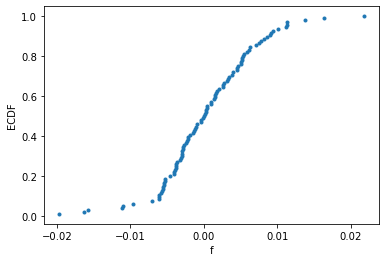

In [105]:
# Compute fractional difference in time between finals and semis
f = (semi_times - final_times) / semi_times

# Generate x and y values for the ECDF: x, y
x , y =dcst.ecdf(f)

# Make a plot of the ECDF
_=plt.plot(x,y, marker='.',linestyle='none')
# Label axes and show plot
_ = plt.xlabel('f')
_ = plt.ylabel('ECDF')
plt.show()

 The median of the ECDF is juuuust above zero. But at first glance, it does not look like there is much of any difference between semifinals and finals. We'll check this carefully in the next exercises.

## Parameter estimates of difference between finals and semifinals
Compute the mean fractional improvement from the semifinals to finals, along with a 95% confidence interval of the mean. The Numpy array f that you computed in the last exercise is in your namespace.#

In [27]:
# Mean fractional time difference: f_mean
f_mean = np.mean(f)
# Get bootstrap reps of mean: bs_reps
bs_reps = dcst.draw_bs_reps(f,np.mean,size=10000)

# Compute confidence intervals: conf_int
conf_int = np.percentile(bs_reps,[2.5,97.5])
# Report
print("""
mean frac. diff.: {0:.5f}
95% conf int of mean frac. diff.: [{1:.5f}, {2:.5f}]""".format(f_mean, *conf_int))


mean frac. diff.: 0.00040
95% conf int of mean frac. diff.: [-0.00090, 0.00173]


It looks like the mean finals time is juuuust faster than the mean semifinal time, and they very well may be the same. We'll test this hypothesis next.

## How to do the permutation test
Based on our EDA and parameter estimates, it is tough to discern improvement from the semifinals to finals. In the next exercise, you will test the hypothesis that there is no difference in performance between the semifinals and finals. A permutation test is fitting for this. We will use the mean value of f as the test statistic. Which of the following simulates getting the test statistic under the null hypothesis?

* Take an array of semifinal times and an array of final times for each swimmer for each stroke/distance pair.
* Go through each array, and for each index, swap the entry in the respective final and semifinal array with a 50% probability.
* Use the resulting final and semifinal arrays to compute f and then the mean of f.

## Generating permutation samples
As you worked out in the last exercise, we need to generate a permutation sample by randomly swapping corresponding entries in the semi_times and final_times array. Write a function with signature swap_random(a, b) that returns arrays where random indices have the entries in a and b swapped.

In [56]:
def swap_random(a, b):
    """Randomly swap entries in two arrays."""
    # Indices to swap
    swap_inds = np.random.random(size=len(a)) < 0.5
    
    # Make copies of arrays a and b for output
    a_out = np.copy(a)
    b_out = np.copy(b)
    
    # Swap values
    a_out[swap_inds] = b[swap_inds]
    b_out[swap_inds] = a[swap_inds]

    return a_out, b_out

## Hypothesis test: Do women swim the same way in semis and finals?
Test the hypothesis that performance in the finals and semifinals are identical using the mean of the fractional improvement as your test statistic. The test statistic under the null hypothesis is considered to be at least as extreme as what was observed if it is greater than or equal to f_mean, which is already in your namespace.

The semifinal and final times are contained in the numpy arrays semi_times and final_times.

In [57]:
# Set up array of permutation replicates
perm_reps = np.empty(1000)

for i in range(1000):
    # Generate a permutation sample
    semi_perm, final_perm = swap_random(semi_times,final_times)
    
    # Compute f from the permutation sample
    f = (semi_perm - final_perm) / semi_perm
    
    # Compute and store permutation replicate
    perm_reps[i] = np.mean(f)

# Compute and print p-value
print('p =', np.sum(perm_reps >= f_mean) / 1000)

p = 0.27


The p-value is large, about 0.27, which suggests that the results of the 2015 World Championships are consistent with there being no difference in performance between the finals and semifinals.

# third topic: How does the performance of swimmers decline over long events?

To answer this question we will pick data following:
* Use women's 800 m freestyle heats
* Omit first and last 100 meters since swimmers go notoriously faster on them
* Compute mean split tile for each split number
* Perform linear regression to get slow down per split


## The datasets

In [79]:
q=""" SELECT athleteid, split, splitswimtime FROM df WHERE gender='F' AND distance=800 and stroke='FREE' AND split NOT IN (1,2,15,16) AND round='PRE'
"""
df_4=ps.sqldf(q)



In [80]:
splits=df_4.pivot(index='athleteid', columns='split',values='splitswimtime').values


In [82]:
split_number=df_4['split'].unique()


## EDA: Plot all your data
To get a graphical overview of a data set, it is often useful to plot all of your data. In this exercise, plot all of the splits for all female swimmers in the 800 meter heats. The data are available in a Numpy arrays split_number and splits. The arrays are organized such that splits[i,j] is the split time for swimmer i for split_number[j].

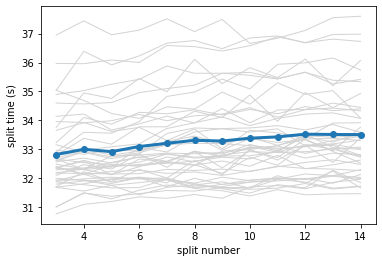

In [86]:
# Plot the splits for each swimmer
for splitset in splits:
    _ = plt.plot(split_number, splitset, linewidth=1, color='lightgray')

# Compute the mean split times
mean_splits = np.mean(splits,axis=0)

# Plot the mean split times
_=plt.plot(split_number,mean_splits,marker='.',linewidth=3,markersize=12)

# Label axes and show plot
_ = plt.xlabel('split number')
_ = plt.ylabel('split time (s)')
plt.show()

You can see that there is wide variability in the splits among the swimmers, and what appears to be a slight trend toward slower split times.

## Linear regression of average split time
We will assume that the swimmers slow down in a linear fashion over the course of the 800 m event. The slowdown per split is then the slope of the mean split time versus split number plot. Perform a linear regression to estimate the slowdown per split and compute a pairs bootstrap 95% confidence interval on the slowdown. Also show a plot of the best fit line.

Note: We can compute error bars for the mean split times and use those in the regression analysis, but we will not take those into account here, as that is beyond the scope of this course.

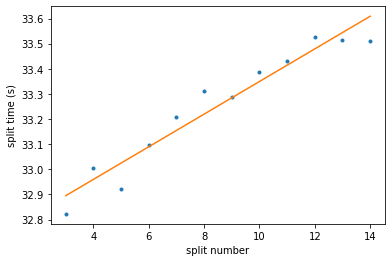


mean slowdown: 0.065 sec./split
95% conf int of mean slowdown: [0.051, 0.079] sec./split


In [84]:
# Perform regression
slowdown, split_3 = np.polyfit(split_number,mean_splits,1)

# Compute pairs bootstrap
bs_reps, _ = dcst.draw_bs_pairs_linreg(split_number,mean_splits,size=10000)

# Compute confidence interval
conf_int = np.percentile(bs_reps,[2.5,97.5])

# Plot the data with regressions line
_ = plt.plot(split_number, mean_splits, marker='.', linestyle='none')
_ = plt.plot(split_number, slowdown * split_number + split_3, '-')

# Label axes and show plot
_ = plt.xlabel('split number')
_ = plt.ylabel('split time (s)')
plt.show()

# Print the slowdown per split
print("""
mean slowdown: {0:.3f} sec./split
95% conf int of mean slowdown: [{1:.3f}, {2:.3f}] sec./split""".format(
    slowdown, *conf_int))

This is a small but discernable slowdown. We are going to run a hypothesis test next.

## Hypothesis test: are they slowing down?
Now we will test the null hypothesis that the swimmer's split time is not at all correlated with the distance they are at in the swim. We will use the Pearson correlation coefficient (computed using dcst.pearson_r()) as the test statistic.

### Hipothesis test for correlation
* Posit null hypothesis: split time and split number are completely uncorrelated
* Simulate data assuming null hypothesis is true
* Use Pearson correlation, denoted as rho, as test statistic
* Compute p-value as the fraction of replicates that have Pearson correlation at least as large as observed.

In [85]:
# Observed correlation
rho = dcst.pearson_r(split_number,mean_splits)

# Initialize permutation reps
perm_reps_rho = np.empty(10000)

# Make permutation reps
for i in range(10000):
    # Scramble the split number array
    scrambled_split_number = np.random.permutation(split_number)
    
    # Compute the Pearson correlation coefficient
    perm_reps_rho[i] = dcst.pearson_r(scrambled_split_number,mean_splits)

    
# Compute and print p-value
p_val = np.sum(perm_reps_rho >= rho) / len(perm_reps_rho)
print('p =', p_val)

p = 0.0


The tiny effect is very real! With 10,000 replicates, we never got a correlation as big as observed under the hypothesis that the swimmers do not change speed as the race progresses. 